In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz

%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

pd.options.display.max_columns= None

### Part 1: Data Cleansing

In [2]:
df = pd.read_csv("Flights Delay Data.csv",low_memory=False)

In [3]:
df

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0,0
1,2013,4,19,5,DL,14869,12478,1705,0.0,0.0,2336,-8.0,0,0
2,2013,4,19,5,DL,14057,14869,600,-4.0,0.0,851,-15.0,0,0
3,2013,4,19,5,DL,15016,11433,1630,28.0,1.0,1903,24.0,1,0
4,2013,4,19,5,DL,11193,12892,1615,-6.0,0.0,1805,-11.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719413,2013,10,19,6,DL,13204,14869,730,1.0,0.0,1013,-3.0,0,0
2719414,2013,10,19,6,DL,10397,13495,944,-2.0,0.0,1018,-3.0,0,0
2719415,2013,10,19,6,DL,10140,10397,1312,18.0,1.0,1807,9.0,0,0
2719416,2013,10,19,6,DL,10397,13244,1735,10.0,0.0,1757,7.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2719418 entries, 0 to 2719417
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Year             int64  
 1   Month            int64  
 2   DayofMonth       int64  
 3   DayOfWeek        int64  
 4   Carrier          object 
 5   OriginAirportID  int64  
 6   DestAirportID    int64  
 7   CRSDepTime       int64  
 8   DepDelay         float64
 9   DepDel15         float64
 10  CRSArrTime       int64  
 11  ArrDelay         float64
 12  ArrDel15         int64  
 13  Cancelled        int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 290.5+ MB


In [5]:
df.describe()

,Year,Month,DayofMonth,DayOfWeek,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
count,2719418.0,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06,2.691974e+06,2.691974e+06,2.719418e+06,2.690385e+06,2.719418e+06,2.719418e+06
mean,2013.0,6.979968e+00,1.579747e+01,3.898391e+00,1.274226e+04,1.274246e+04,1.326645e+03,1.053687e+01,2.023419e-01,1.505270e+03,6.637688e+00,2.166316e-01,1.067618e-02
std,0.0,1.984331e+00,8.799860e+00,1.985988e+00,1.501973e+03,1.501969e+03,4.713766e+02,3.609953e+01,4.017458e-01,4.939662e+02,3.864881e+01,4.119496e-01,1.027726e-01
min,2013.0,4.000000e+00,1.000000e+00,1.000000e+00,1.014000e+04,1.014000e+04,1.000000e+00,-6.300000e+01,0.000000e+00,1.000000e+00,-9.400000e+01,0.000000e+00,0.000000e+00
25%,2013.0,5.000000e+00,8.000000e+00,2.000000e+00,1.129200e+04,1.129200e+04,9.200000e+02,-4.000000e+00,0.000000e+00,1.120000e+03,-1.100000e+01,0.000000e+00,0.000000e+00
50%,2013.0,7.000000e+00,1.600000e+01,4.000000e+00,1.289200e+04,1.289200e+04,1.320000e+03,-1.000000e+00,0.000000e+00,1.528000e+03,-3.000000e+00,0.000000e+00,0.000000e+00
75%,2013.0,9.000000e+00,2.300000e+01,6.000000e+00,1.405700e+04,1.405700e+04,1.725000e+03,9.000000e+00,0.000000e+00,1.918000e+03,1.000000e+01,0.000000e+00,0.000000e+00
max,2013.0,1.000000e+01,3.100000e+01,7.000000e+00,1.537600e+04,1.537600e+04,2.359000e+03,1.863000e+03,1.000000e+00,2.359000e+03,1.845000e+03,1.000000e+00,1.000000e+00


In [6]:
df.isnull().sum()

Year                   0
Month                  0
DayofMonth             0
DayOfWeek              0
Carrier                0
OriginAirportID        0
DestAirportID          0
CRSDepTime             0
DepDelay           27444
DepDel15           27444
CRSArrTime             0
ArrDelay           29033
ArrDel15               0
Cancelled              0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.shape

(2719418, 14)

### Join datasets

In [9]:
df2 = pd.read_csv('Airport Codes Dataset.csv')

In [10]:
df2

,airport_id,city,state,name
0,10165,Adak Island,AK,Adak
1,10299,Anchorage,AK,Ted Stevens Anchorage International
2,10304,Aniak,AK,Aniak Airport
3,10754,Barrow,AK,Wiley Post/Will Rogers Memorial
4,10551,Bethel,AK,Bethel Airport
...,...,...,...,...
360,11233,Cheyenne,WY,Cheyenne Regional/Jerry Olson Field
361,11097,Cody,WY,Yellowstone Regional
362,11865,Gillette,WY,Gillette Campbell County
363,12441,Jackson,WY,Jackson Hole


In [11]:
origin_df = pd.merge(left=df,right=df2,how='inner',left_on='OriginAirportID',right_on='airport_id')

In [12]:
origin_df

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled,airport_id,city,state,name
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0,0,11433,Detroit,MI,Detroit Metro Wayne County
1,2013,4,19,5,DL,11433,11298,835,22.0,1.0,1035,41.0,1,0,11433,Detroit,MI,Detroit Metro Wayne County
2,2013,4,19,5,DL,11433,12892,1935,-2.0,0.0,2140,-7.0,0,0,11433,Detroit,MI,Detroit Metro Wayne County
3,2013,4,19,5,DL,11433,12953,725,-3.0,0.0,918,-10.0,0,0,11433,Detroit,MI,Detroit Metro Wayne County
4,2013,4,20,6,DL,11433,13487,725,-3.0,0.0,823,-5.0,0,0,11433,Detroit,MI,Detroit Metro Wayne County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719413,2013,10,27,7,AS,13891,14747,1035,-12.0,0.0,1305,4.0,0,0,13891,Ontario,CA,Ontario International
2719414,2013,10,27,7,AS,13891,14747,615,-7.0,0.0,858,0.0,0,0,13891,Ontario,CA,Ontario International
2719415,2013,10,31,4,AS,13891,14747,1740,-10.0,0.0,2015,-11.0,0,0,13891,Ontario,CA,Ontario International
2719416,2013,10,31,4,AS,13891,14747,1035,-10.0,0.0,1305,-7.0,0,0,13891,Ontario,CA,Ontario International


In [13]:
#Save to csv
#origin_df.to_csv("origin.csv",index=False)

In [14]:
dest_df = pd.merge(left=df,right=df2,how='inner',left_on='DestAirportID',right_on='airport_id')

In [15]:
dest_df

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled,airport_id,city,state,name
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0,0,13303,Miami,FL,Miami International
1,2013,4,18,4,DL,11433,13303,1948,103.0,1.0,2253,90.0,1,0,13303,Miami,FL,Miami International
2,2013,4,18,4,DL,10397,13303,1242,3.0,0.0,1433,-3.0,0,0,13303,Miami,FL,Miami International
3,2013,4,19,5,DL,10397,13303,730,4.0,0.0,921,2.0,0,0,13303,Miami,FL,Miami International
4,2013,4,19,5,DL,12478,13303,800,1.0,0.0,1118,11.0,0,0,13303,Miami,FL,Miami International
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719413,2013,10,27,7,AS,14747,13891,1425,-1.0,0.0,1648,-2.0,0,0,13891,Ontario,CA,Ontario International
2719414,2013,10,27,7,AS,14747,13891,2035,-2.0,0.0,2300,-2.0,0,0,13891,Ontario,CA,Ontario International
2719415,2013,10,31,4,AS,14747,13891,725,-2.0,0.0,953,-16.0,0,0,13891,Ontario,CA,Ontario International
2719416,2013,10,31,4,AS,14747,13891,1425,-5.0,0.0,1648,-7.0,0,0,13891,Ontario,CA,Ontario International


In [16]:
#Save to csv
#dest_df.to_csv('dest.csv',index=False)

In [17]:
dest_df['name'].value_counts()

 Hartsfield-Jackson Atlanta International    150029
 Chicago O'Hare International                127902
 Los Angeles International                   119062
 Dallas/Fort Worth International             104730
 Denver International                         97264
                                              ...  
 Palm Beach International                     10142
 Norfolk International                        10057
 Theodore Francis Green State                  9358
 Long Beach Airport                            8208
 Ted Stevens Anchorage International           7779
Name: name, Length: 70, dtype: int64

### Remove Duplicates

In [18]:
origin_df.duplicated().sum()

0

In [19]:
dest_df.duplicated().sum()

0

### Clean Missing Values

In [20]:
origin_df.isnull().sum()

Year                   0
Month                  0
DayofMonth             0
DayOfWeek              0
Carrier                0
OriginAirportID        0
DestAirportID          0
CRSDepTime             0
DepDelay           27444
DepDel15           27444
CRSArrTime             0
ArrDelay           29033
ArrDel15               0
Cancelled              0
airport_id             0
city                   0
state                  0
name                   0
dtype: int64

In [21]:
origin_df.fillna(0.0,inplace=True)

In [22]:
origin_df.isnull().sum()

Year               0
Month              0
DayofMonth         0
DayOfWeek          0
Carrier            0
OriginAirportID    0
DestAirportID      0
CRSDepTime         0
DepDelay           0
DepDel15           0
CRSArrTime         0
ArrDelay           0
ArrDel15           0
Cancelled          0
airport_id         0
city               0
state              0
name               0
dtype: int64

In [23]:
origin_df.shape

(2719418, 18)

In [24]:
origin_df['ArrDelay'].mean()

6.566822753986331

In [25]:
dest_df.isnull().sum()

Year                   0
Month                  0
DayofMonth             0
DayOfWeek              0
Carrier                0
OriginAirportID        0
DestAirportID          0
CRSDepTime             0
DepDelay           27444
DepDel15           27444
CRSArrTime             0
ArrDelay           29033
ArrDel15               0
Cancelled              0
airport_id             0
city                   0
state                  0
name                   0
dtype: int64

In [26]:
dest_df.fillna(0.0,inplace=True)

In [27]:
dest_df.isnull().sum()

Year               0
Month              0
DayofMonth         0
DayOfWeek          0
Carrier            0
OriginAirportID    0
DestAirportID      0
CRSDepTime         0
DepDelay           0
DepDel15           0
CRSArrTime         0
ArrDelay           0
ArrDel15           0
Cancelled          0
airport_id         0
city               0
state              0
name               0
dtype: int64

In [28]:
dest_df.shape

(2719418, 18)

In [29]:
dest_df['ArrDelay'].mean()

6.566822753986331

In [30]:
#Save to csv
#origin_df.to_csv("origin.csv",index=False)

In [31]:
#Save to csv
#dest_df.to_csv('dest.csv',index=False)

### Data Exploration

In [32]:
origin_df.describe()

,Year,Month,DayofMonth,DayOfWeek,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled,airport_id
count,2719418.0,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06
mean,2013.0,6.979968e+00,1.579747e+01,3.898391e+00,1.274226e+04,1.274246e+04,1.326645e+03,1.043053e+01,2.002998e-01,1.505270e+03,6.566823e+00,2.166316e-01,1.067618e-02,1.274226e+04
std,0.0,1.984331e+00,8.799860e+00,1.985988e+00,1.501973e+03,1.501969e+03,4.713766e+02,3.593235e+01,4.002248e-01,4.939662e+02,3.844800e+01,4.119496e-01,1.027726e-01,1.501973e+03
min,2013.0,4.000000e+00,1.000000e+00,1.000000e+00,1.014000e+04,1.014000e+04,1.000000e+00,-6.300000e+01,0.000000e+00,1.000000e+00,-9.400000e+01,0.000000e+00,0.000000e+00,1.014000e+04
25%,2013.0,5.000000e+00,8.000000e+00,2.000000e+00,1.129200e+04,1.129200e+04,9.200000e+02,-4.000000e+00,0.000000e+00,1.120000e+03,-1.100000e+01,0.000000e+00,0.000000e+00,1.129200e+04
50%,2013.0,7.000000e+00,1.600000e+01,4.000000e+00,1.289200e+04,1.289200e+04,1.320000e+03,-1.000000e+00,0.000000e+00,1.528000e+03,-3.000000e+00,0.000000e+00,0.000000e+00,1.289200e+04
75%,2013.0,9.000000e+00,2.300000e+01,6.000000e+00,1.405700e+04,1.405700e+04,1.725000e+03,9.000000e+00,0.000000e+00,1.918000e+03,1.000000e+01,0.000000e+00,0.000000e+00,1.405700e+04
max,2013.0,1.000000e+01,3.100000e+01,7.000000e+00,1.537600e+04,1.537600e+04,2.359000e+03,1.863000e+03,1.000000e+00,2.359000e+03,1.845000e+03,1.000000e+00,1.000000e+00,1.537600e+04


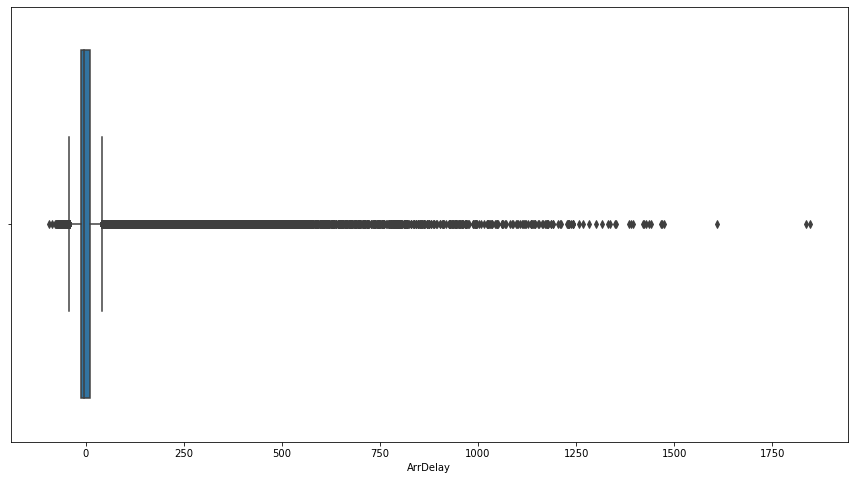

In [33]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x=origin_df.ArrDelay, ax=ax)
plt.show()

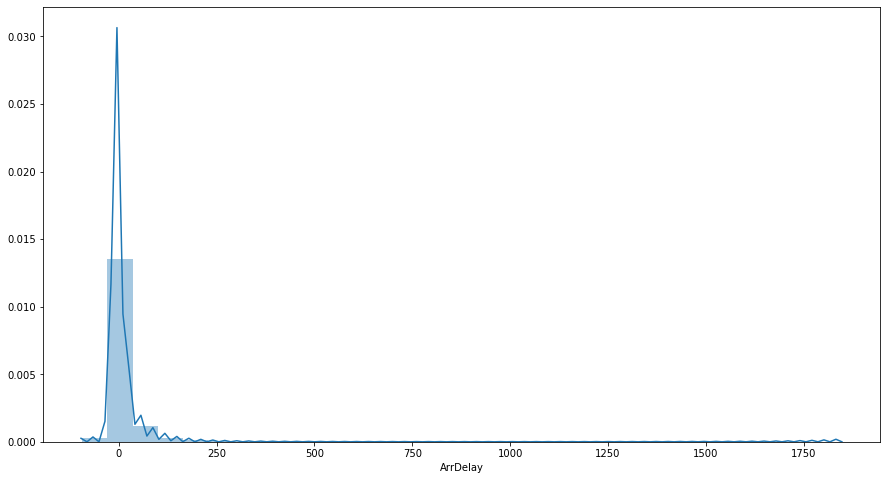

In [34]:
fig, ax = plt.subplots(figsize=(15,8))
sns.distplot(origin_df.ArrDelay, ax=ax, bins=30)
plt.show()

In [35]:
origin_df.ArrDelay.max() - origin_df.ArrDelay.min()

1939.0

In [36]:
origin_df['ArrDelay'].value_counts()

 0.0      94578
-7.0      82109
-6.0      81511
-8.0      81192
-9.0      80350
          ...  
 911.0        1
 913.0        1
 919.0        1
 929.0        1
 473.0        1
Name: ArrDelay, Length: 979, dtype: int64

In [37]:
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2719418 entries, 0 to 2719417
Data columns (total 18 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Year             int64  
 1   Month            int64  
 2   DayofMonth       int64  
 3   DayOfWeek        int64  
 4   Carrier          object 
 5   OriginAirportID  int64  
 6   DestAirportID    int64  
 7   CRSDepTime       int64  
 8   DepDelay         float64
 9   DepDel15         float64
 10  CRSArrTime       int64  
 11  ArrDelay         float64
 12  ArrDel15         int64  
 13  Cancelled        int64  
 14  airport_id       int64  
 15  city             object 
 16  state            object 
 17  name             object 
dtypes: float64(3), int64(11), object(4)
memory usage: 394.2+ MB


In [38]:
origin_df_num = origin_df.select_dtypes(exclude='object')

In [39]:
origin_df_num

,Year,Month,DayofMonth,DayOfWeek,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled,airport_id
0,2013,4,19,5,11433,13303,837,-3.0,0.0,1138,1.0,0,0,11433
1,2013,4,19,5,11433,11298,835,22.0,1.0,1035,41.0,1,0,11433
2,2013,4,19,5,11433,12892,1935,-2.0,0.0,2140,-7.0,0,0,11433
3,2013,4,19,5,11433,12953,725,-3.0,0.0,918,-10.0,0,0,11433
4,2013,4,20,6,11433,13487,725,-3.0,0.0,823,-5.0,0,0,11433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719413,2013,10,27,7,13891,14747,1035,-12.0,0.0,1305,4.0,0,0,13891
2719414,2013,10,27,7,13891,14747,615,-7.0,0.0,858,0.0,0,0,13891
2719415,2013,10,31,4,13891,14747,1740,-10.0,0.0,2015,-11.0,0,0,13891
2719416,2013,10,31,4,13891,14747,1035,-10.0,0.0,1305,-7.0,0,0,13891


In [40]:
origin_df_num_select = origin_df_num[['DepDelay','CRSArrTime','CRSDepTime','DayofMonth','DayOfWeek','Month','ArrDelay'
]]

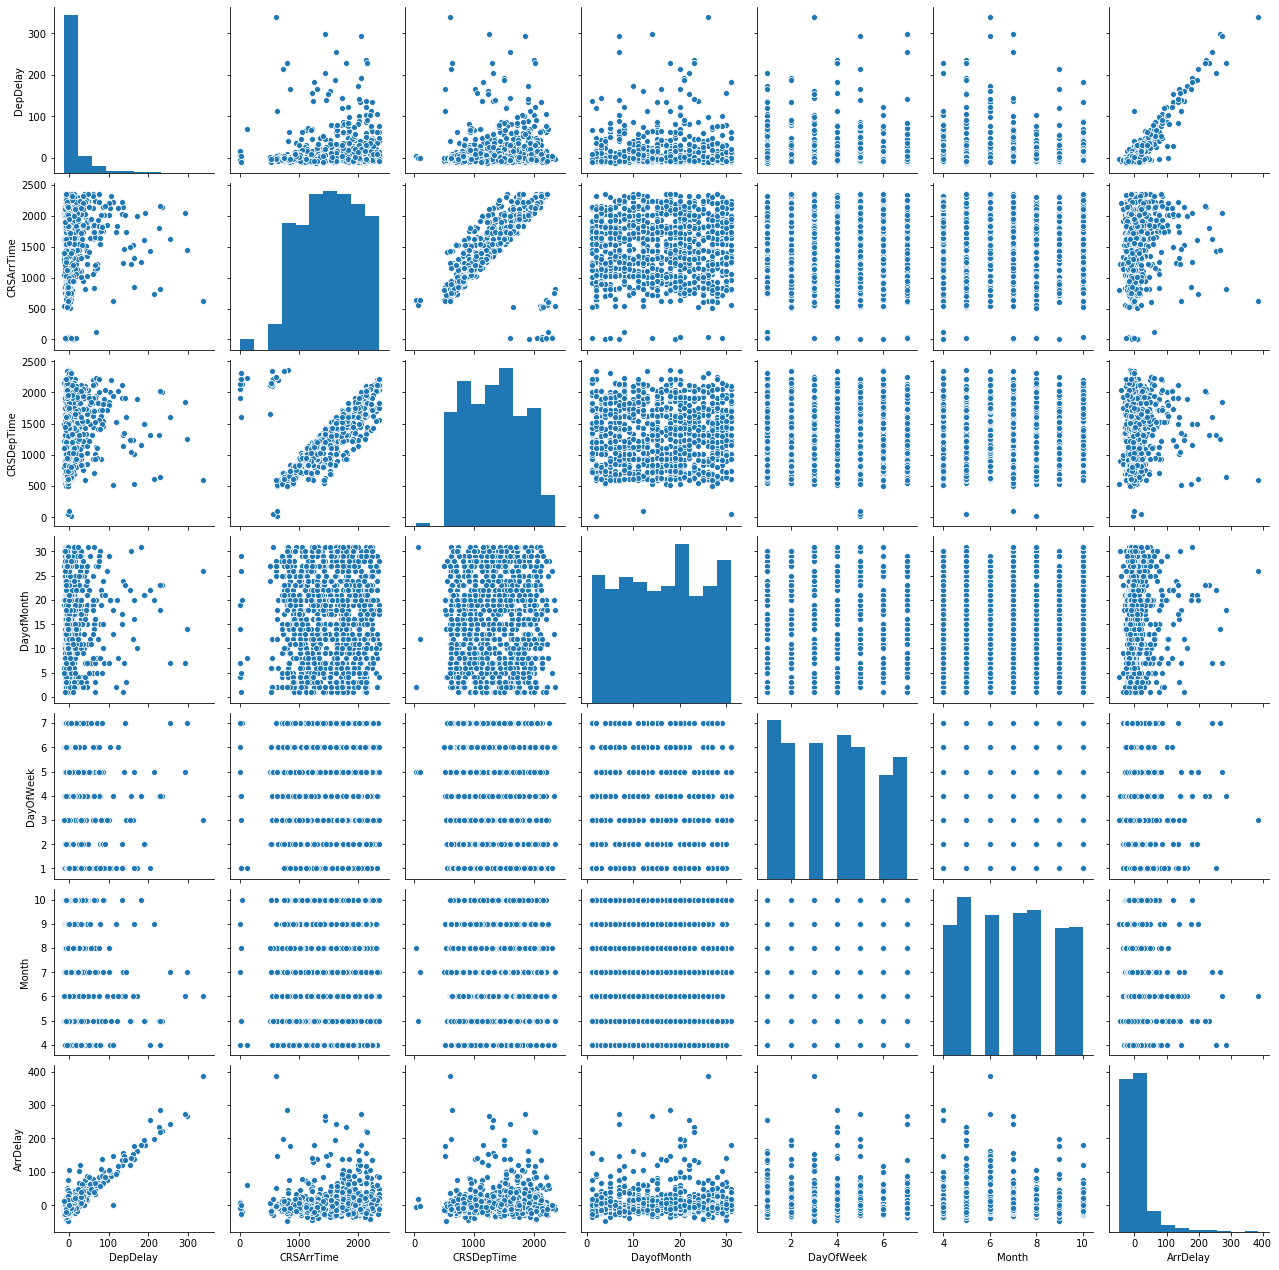

In [41]:
sns.pairplot(origin_df_num_select.sample(1000))
plt.show()

In [42]:
len(origin_df_num_select[origin_df_num_select['DepDelay'] > 15])

523452

In [43]:
2719418 - 523452

2195966

In [44]:
sns.__version__

'0.10.0'

### Train a Regression Model

In [45]:
df

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0,0
1,2013,4,19,5,DL,14869,12478,1705,0.0,0.0,2336,-8.0,0,0
2,2013,4,19,5,DL,14057,14869,600,-4.0,0.0,851,-15.0,0,0
3,2013,4,19,5,DL,15016,11433,1630,28.0,1.0,1903,24.0,1,0
4,2013,4,19,5,DL,11193,12892,1615,-6.0,0.0,1805,-11.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719413,2013,10,19,6,DL,13204,14869,730,1.0,0.0,1013,-3.0,0,0
2719414,2013,10,19,6,DL,10397,13495,944,-2.0,0.0,1018,-3.0,0,0
2719415,2013,10,19,6,DL,10140,10397,1312,18.0,1.0,1807,9.0,0,0
2719416,2013,10,19,6,DL,10397,13244,1735,10.0,0.0,1757,7.0,0,0


### Due to Excel and Github limitations, will reduce the rows numbers

In [46]:
dfnew = df[0:900000]

In [47]:
dfnew

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0,0
1,2013,4,19,5,DL,14869,12478,1705,0.0,0.0,2336,-8.0,0,0
2,2013,4,19,5,DL,14057,14869,600,-4.0,0.0,851,-15.0,0,0
3,2013,4,19,5,DL,15016,11433,1630,28.0,1.0,1903,24.0,1,0
4,2013,4,19,5,DL,11193,12892,1615,-6.0,0.0,1805,-11.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,2013,6,13,4,AA,11298,12889,1410,-2.0,0.0,1500,-21.0,0,0
899996,2013,6,14,5,AA,11298,12889,1410,32.0,1.0,1500,17.0,1,0
899997,2013,6,15,6,AA,11298,12889,1410,19.0,1.0,1500,12.0,0,0
899998,2013,6,16,7,AA,11298,12889,1410,6.0,0.0,1500,3.0,0,0


In [48]:
df_train = dfnew[['Month', 'DayofMonth', 'DayOfWeek', 'Carrier', 'OriginAirportID', 'DestAirportID',
               'CRSDepTime', 'DepDelay', 'CRSArrTime','ArrDelay' ]]

In [49]:
df_train

,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,CRSArrTime,ArrDelay
0,4,19,5,DL,11433,13303,837,-3.0,1138,1.0
1,4,19,5,DL,14869,12478,1705,0.0,2336,-8.0
2,4,19,5,DL,14057,14869,600,-4.0,851,-15.0
3,4,19,5,DL,15016,11433,1630,28.0,1903,24.0
4,4,19,5,DL,11193,12892,1615,-6.0,1805,-11.0
...,...,...,...,...,...,...,...,...,...,...
899995,6,13,4,AA,11298,12889,1410,-2.0,1500,-21.0
899996,6,14,5,AA,11298,12889,1410,32.0,1500,17.0
899997,6,15,6,AA,11298,12889,1410,19.0,1500,12.0
899998,6,16,7,AA,11298,12889,1410,6.0,1500,3.0


In [50]:
df_train.nunique()

Month                 3
DayofMonth           31
DayOfWeek             7
Carrier              16
OriginAirportID      70
DestAirportID        70
CRSDepTime         1204
DepDelay            752
CRSArrTime         1303
ArrDelay            791
dtype: int64

In [51]:
df_train.drop(['Carrier', 'OriginAirportID', 'DestAirportID'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [52]:
df_train

,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,CRSArrTime,ArrDelay
0,4,19,5,837,-3.0,1138,1.0
1,4,19,5,1705,0.0,2336,-8.0
2,4,19,5,600,-4.0,851,-15.0
3,4,19,5,1630,28.0,1903,24.0
4,4,19,5,1615,-6.0,1805,-11.0
...,...,...,...,...,...,...,...
899995,6,13,4,1410,-2.0,1500,-21.0
899996,6,14,5,1410,32.0,1500,17.0
899997,6,15,6,1410,19.0,1500,12.0
899998,6,16,7,1410,6.0,1500,3.0


In [53]:
#Save to csv
#df_train.to_csv("train.csv",index=False)

### Add in Additional test values to train dataset for Standardization

In [54]:
train = pd.read_csv("train1.csv")

In [55]:
train

,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,CRSArrTime,ArrDelay
0,4,19,5,837,-3.0,1138,1.0
1,4,19,5,1705,0.0,2336,-8.0
2,4,19,5,600,-4.0,851,-15.0
3,4,19,5,1630,28.0,1903,24.0
4,4,19,5,1615,-6.0,1805,-11.0
...,...,...,...,...,...,...,...
899999,6,17,1,1410,78.0,1500,78.0
900000,4,19,5,837,-3.0,1138,0.0
900001,5,6,1,1805,0.0,2105,0.0
900002,6,19,3,945,-4.0,1201,0.0


In [56]:
train.isnull().sum()

Month             0
DayofMonth        0
DayOfWeek         0
CRSDepTime        0
DepDelay      10998
CRSArrTime        0
ArrDelay      11577
dtype: int64

In [57]:
train.fillna(value=0.0,inplace=True)

In [58]:
train.isnull().sum()

Month         0
DayofMonth    0
DayOfWeek     0
CRSDepTime    0
DepDelay      0
CRSArrTime    0
ArrDelay      0
dtype: int64

In [59]:
X = train.iloc[:,0:6]
y = train.iloc[:,6]

In [60]:
X.tail()

,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,CRSArrTime
899999,6,17,1,1410,78.0,1500
900000,4,19,5,837,-3.0,1138
900001,5,6,1,1805,0.0,2105
900002,6,19,3,945,-4.0,1201
900003,6,20,4,1750,84.0,1935


In [61]:
scaler = StandardScaler()

In [62]:
X_scaled = scaler.fit_transform(X)

In [63]:
X_scaled

array([[-1.02542417,  0.3902935 ,  0.57377021, -1.03438736, -0.37107321,
        -0.73176787],
       [-1.02542417,  0.3902935 ,  0.57377021,  0.79472824, -0.29130477,
         1.66383056],
       [-1.02542417,  0.3902935 ,  0.57377021, -1.53381178, -0.39766269,
        -1.30567166],
       ...,
       [ 0.41570004, -1.08522226, -1.45568139,  1.00545584, -0.29130477,
         1.20190799],
       [ 1.85682424,  0.3902935 , -0.44095559, -0.80680155, -0.39766269,
        -0.60578898],
       [ 1.85682424,  0.50379471,  0.06640731,  0.88955566,  1.94221153,
         0.86196498]])

In [64]:
X_scaled_df = pd.DataFrame(X_scaled,columns=X.columns)

In [65]:
X_scaled_df

,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,CRSArrTime
0,-1.025424,0.390293,0.573770,-1.034387,-0.371073,-0.731768
1,-1.025424,0.390293,0.573770,0.794728,-0.291305,1.663831
2,-1.025424,0.390293,0.573770,-1.533812,-0.397663,-1.305672
3,-1.025424,0.390293,0.573770,0.636683,0.453201,0.797976
4,-1.025424,0.390293,0.573770,0.605073,-0.450842,0.602009
...,...,...,...,...,...,...
899999,1.856824,0.163291,-1.455681,0.173082,1.782675,-0.007889
900000,-1.025424,0.390293,0.573770,-1.034387,-0.371073,-0.731768
900001,0.415700,-1.085222,-1.455681,1.005456,-0.291305,1.201908
900002,1.856824,0.390293,-0.440956,-0.806802,-0.397663,-0.605789


In [66]:
label = train['ArrDelay']

In [67]:
label

0          1.0
1         -8.0
2        -15.0
3         24.0
4        -11.0
          ... 
899999    78.0
900000     0.0
900001     0.0
900002     0.0
900003     0.0
Name: ArrDelay, Length: 900004, dtype: float64

In [68]:
train2 = pd.concat([X_scaled_df,label],axis=1)

In [69]:
train2

,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,CRSArrTime,ArrDelay
0,-1.025424,0.390293,0.573770,-1.034387,-0.371073,-0.731768,1.0
1,-1.025424,0.390293,0.573770,0.794728,-0.291305,1.663831,-8.0
2,-1.025424,0.390293,0.573770,-1.533812,-0.397663,-1.305672,-15.0
3,-1.025424,0.390293,0.573770,0.636683,0.453201,0.797976,24.0
4,-1.025424,0.390293,0.573770,0.605073,-0.450842,0.602009,-11.0
...,...,...,...,...,...,...,...
899999,1.856824,0.163291,-1.455681,0.173082,1.782675,-0.007889,78.0
900000,-1.025424,0.390293,0.573770,-1.034387,-0.371073,-0.731768,0.0
900001,0.415700,-1.085222,-1.455681,1.005456,-0.291305,1.201908,0.0
900002,1.856824,0.390293,-0.440956,-0.806802,-0.397663,-0.605789,0.0


In [70]:
#Save to csv
#train2.to_csv("train2.csv",index=False)

In [71]:
train3 = train2[0:900000]

In [72]:
train3

,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,CRSArrTime,ArrDelay
0,-1.025424,0.390293,0.573770,-1.034387,-0.371073,-0.731768,1.0
1,-1.025424,0.390293,0.573770,0.794728,-0.291305,1.663831,-8.0
2,-1.025424,0.390293,0.573770,-1.533812,-0.397663,-1.305672,-15.0
3,-1.025424,0.390293,0.573770,0.636683,0.453201,0.797976,24.0
4,-1.025424,0.390293,0.573770,0.605073,-0.450842,0.602009,-11.0
...,...,...,...,...,...,...,...
899995,1.856824,-0.290714,0.066407,0.173082,-0.344484,-0.007889,-21.0
899996,1.856824,-0.177213,0.573770,0.173082,0.559559,-0.007889,17.0
899997,1.856824,-0.063711,1.081133,0.173082,0.213895,-0.007889,12.0
899998,1.856824,0.049790,1.588496,0.173082,-0.131768,-0.007889,3.0


In [73]:
test = train2[900000:]

In [74]:
test

,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,CRSArrTime,ArrDelay
900000,-1.025424,0.390293,0.573770,-1.034387,-0.371073,-0.731768,0.0
900001,0.415700,-1.085222,-1.455681,1.005456,-0.291305,1.201908,0.0
900002,1.856824,0.390293,-0.440956,-0.806802,-0.397663,-0.605789,0.0
900003,1.856824,0.503795,0.066407,0.889556,1.942212,0.861965,0.0


In [75]:
test = test.drop('ArrDelay',axis=1)

In [76]:
test

,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,CRSArrTime
900000,-1.025424,0.390293,0.573770,-1.034387,-0.371073,-0.731768
900001,0.415700,-1.085222,-1.455681,1.005456,-0.291305,1.201908
900002,1.856824,0.390293,-0.440956,-0.806802,-0.397663,-0.605789
900003,1.856824,0.503795,0.066407,0.889556,1.942212,0.861965


In [77]:
#Save to csv
#test.to_csv("test.csv",index=False)

In [78]:
X = train3.iloc[:,0:6]
y = train3.iloc[:,6]

In [79]:
X.values, y.values

(array([[-1.02542417,  0.3902935 ,  0.57377021, -1.03438736, -0.37107321,
         -0.73176787],
        [-1.02542417,  0.3902935 ,  0.57377021,  0.79472824, -0.29130477,
          1.66383056],
        [-1.02542417,  0.3902935 ,  0.57377021, -1.53381178, -0.39766269,
         -1.30567166],
        ...,
        [ 1.85682424, -0.06371135,  1.0811331 ,  0.17308181,  0.21389534,
         -0.00788921],
        [ 1.85682424,  0.04978986,  1.588496  ,  0.17308181, -0.13176789,
         -0.00788921],
        [ 1.85682424,  0.16329107, -1.45568139,  0.17308181,  1.78267465,
         -0.00788921]]),
 array([  1.,  -8., -15., ...,  12.,   3.,  78.]))

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [81]:
X_train.shape, X_test.shape

((630000, 6), (270000, 6))

In [82]:
xgb = XGBRegressor(random_state=0, n_estimators=400, objective='reg:squarederror')

In [83]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',early_stopping_rounds=20)

[0]	validation_0-rmse:37.4832
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:34.4411
[2]	validation_0-rmse:31.7153
[3]	validation_0-rmse:29.3134
[4]	validation_0-rmse:27.2059
[5]	validation_0-rmse:25.3475
[6]	validation_0-rmse:23.7085
[7]	validation_0-rmse:22.2644
[8]	validation_0-rmse:21.0182
[9]	validation_0-rmse:19.9419
[10]	validation_0-rmse:18.9975
[11]	validation_0-rmse:18.1945
[12]	validation_0-rmse:17.5064
[13]	validation_0-rmse:16.9189
[14]	validation_0-rmse:16.4231
[15]	validation_0-rmse:16.0044
[16]	validation_0-rmse:15.6555
[17]	validation_0-rmse:15.3618
[18]	validation_0-rmse:15.1157
[19]	validation_0-rmse:14.9143
[20]	validation_0-rmse:14.746
[21]	validation_0-rmse:14.599
[22]	validation_0-rmse:14.4757
[23]	validation_0-rmse:14.3751
[24]	validation_0-rmse:14.2938
[25]	validation_0-rmse:14.223
[26]	validation_0-rmse:14.1653
[27]	validation_0-rmse:14.118
[28]	validation_0-rmse:14.0761
[29]	validation_0-rmse:14.0441
[30]	validation_0-r

[259]	validation_0-rmse:13.6984
[260]	validation_0-rmse:13.6983
[261]	validation_0-rmse:13.6981
[262]	validation_0-rmse:13.6976
[263]	validation_0-rmse:13.6974
[264]	validation_0-rmse:13.6971
[265]	validation_0-rmse:13.6972
[266]	validation_0-rmse:13.6971
[267]	validation_0-rmse:13.6968
[268]	validation_0-rmse:13.6966
[269]	validation_0-rmse:13.6966
[270]	validation_0-rmse:13.696
[271]	validation_0-rmse:13.6952
[272]	validation_0-rmse:13.6951
[273]	validation_0-rmse:13.6947
[274]	validation_0-rmse:13.6944
[275]	validation_0-rmse:13.6941
[276]	validation_0-rmse:13.6935
[277]	validation_0-rmse:13.6932
[278]	validation_0-rmse:13.6928
[279]	validation_0-rmse:13.6921
[280]	validation_0-rmse:13.692
[281]	validation_0-rmse:13.6918
[282]	validation_0-rmse:13.6915
[283]	validation_0-rmse:13.6914
[284]	validation_0-rmse:13.6911
[285]	validation_0-rmse:13.691
[286]	validation_0-rmse:13.6908
[287]	validation_0-rmse:13.6906
[288]	validation_0-rmse:13.6907
[289]	validation_0-rmse:13.6909
[290]	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [84]:
y_pred = xgb.predict(X_test)

In [85]:
y_pred

array([-10.436218 ,  41.72083  ,  -1.5466876, ...,  -5.1523585,
        -8.931841 ,  -9.628641 ], dtype=float32)

In [86]:
mse = mean_squared_error(y_test,y_pred)
mse

186.93092429914213

In [87]:
rmse = np.sqrt(mse)
rmse

13.672268440136119

In [88]:
r2score = r2_score(y_test,y_pred)
r2score

0.885243045934208

Text(0.5, 0, 'Actual')

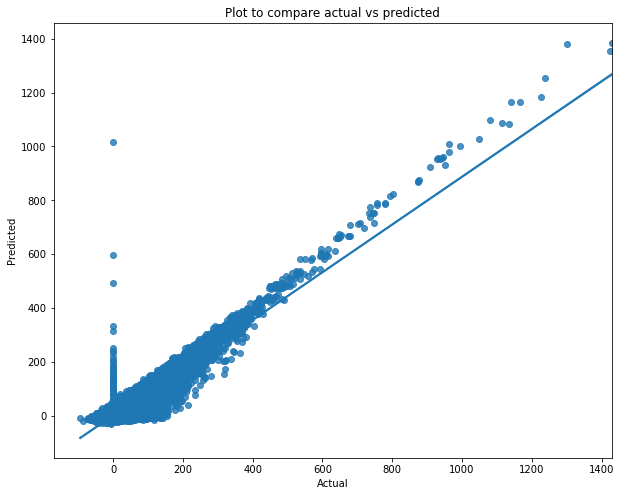

In [89]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")

### Prediction

In [90]:
test.values

array([[-1.02542417,  0.3902935 ,  0.57377021, -1.03438736, -0.37107321,
        -0.73176787],
       [ 0.41570004, -1.08522226, -1.45568139,  1.00545584, -0.29130477,
         1.20190799],
       [ 1.85682424,  0.3902935 , -0.44095559, -0.80680155, -0.39766269,
        -0.60578898],
       [ 1.85682424,  0.50379471,  0.06640731,  0.88955566,  1.94221153,
         0.86196498]])

In [91]:
answer = xgb.predict(test)

In [92]:
answer

array([-4.9311275, -5.8304563, -7.2870474, 83.02802  ], dtype=float32)

### These are predicted values as above. 